In [1]:
#!/usr/bin/python3
# -*- coding: UTF-8 -*-
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.autograd import Variable
from teacherNet import Teacher
from studentNet import CNN_RIS

def preprocess_image(cv2im, mean, std, resize_Teacher=True):
    """
        Processes image for CNNs

    Args:
        PIL_img (PIL_img): Image to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (Pytorch variable): Variable that contains processed float tensor
    """
    # Resize image
    if resize_Teacher:  
        cv2im = cv2.resize(cv2im, (92, 92))
    else:
        cv2im = cv2.resize(cv2im, (44, 44))
    im_as_arr = np.float32(cv2im)
    im_as_arr = np.ascontiguousarray(im_as_arr[..., ::-1])
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var


def preprocess_feature(feature):
    feature = feature.data.numpy()
    #use sigmod to [0,1]
    feature= 1.0/(1+np.exp(-1*feature))
    # to [0,255]
    feature=np.squeeze(np.round(feature*255))
    return feature

def preprocess_feature2(feature):
    feature = feature.data.numpy()
    #use sigmod to [0,1]
    feature= 1.0/(1+np.exp(-1*feature))
    # to [0,255]
    feature=np.round(feature*255)
    return feature

In [2]:
img = cv2.imread('train_09123.jpg')

tnet = Teacher()
tcheckpoint = torch.load('results/RAF_Teacher_False/Best_Teacher_model.t7')
tnet.load_state_dict(tcheckpoint['tnet'], strict=False)
tmean = [0.5884594, 0.45767313, 0.40865755]
tstd = [0.25717735, 0.23602168, 0.23505741]
timg = preprocess_image(img, tmean, tstd, resize_Teacher=True)

snet = CNN_RIS()
scheckpoint = torch.load('results/RAF_Student_False/PrivateTest_model.t7')
snet.load_state_dict(scheckpoint['net'], strict=False)
smean = [0.58846486, 0.45766878, 0.40865615]
sstd = [0.2516557, 0.23020789, 0.22939532]
simg = preprocess_image(img, smean, sstd, resize_Teacher=False)

with torch.no_grad():
    rb1_t, rb2_t, rb3_t, mimic_t, out_t = tnet(timg)
    rb1_s, rb2_s, rb3_s, mimic_s, out_s = snet(simg)

    
rb1_t = preprocess_feature(rb1_t)
rb1_s = preprocess_feature(rb1_s)

(46, 46)


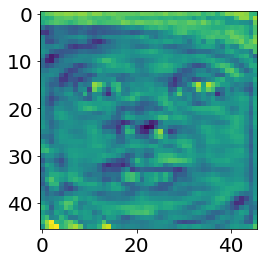

In [3]:
rb1_t = rb1_t[0,:,:]
print (rb1_t.shape)
plt.figure("rb1_t") # 图像窗口名称
plt.imshow(rb1_t)
plt.axis('on') # 关掉坐标轴为 off
plt.tick_params(labelsize=20)
# plt.title('A feature of ResBlock(1) in TeacherNet') # 图像题目
plt.savefig('./transformation/teacher.jpg')
plt.show()

(46, 46)
torch.Size([23, 23])


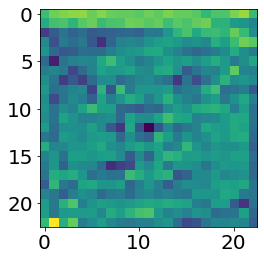

In [4]:
print (rb1_t.shape)
rb2_t = torch.nn.functional.interpolate(torch.from_numpy(rb1_t).unsqueeze(0).unsqueeze(0), size=[23, 23], mode='nearest', align_corners=None).squeeze(0).squeeze(0)
print (rb2_t.shape)
plt.figure("rb2_t") # 图像窗口名称
plt.imshow(rb2_t)
plt.axis('on') # 关掉为 off
plt.tick_params(labelsize=20)
plt.savefig('./transformation/teacher_downsamping.jpg')
plt.show()

(46, 46)
torch.Size([100, 2116])


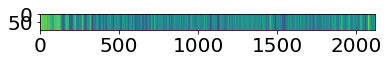

In [5]:
print (rb1_t.shape)
rb3_t = torch.from_numpy(rb1_t).view(1, 2116).expand(100, 2116)
print (rb3_t.shape)
plt.figure("rb3_t") # 图像窗口名称
plt.imshow(rb3_t)
plt.axis('on') # 关掉坐标轴为 off
plt.tick_params(labelsize=20)
# plt.title('A feature of ResBlock(1) in TeacherNet') # 图像题目
plt.savefig('./transformation/teacher_onevetor.jpg')
plt.show()

(22, 22)


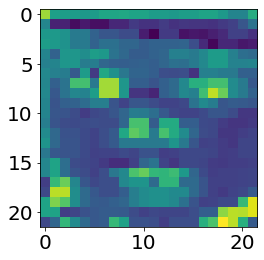

In [6]:
rb1_s = rb1_s[0,:,:]
print (rb1_s.shape)
plt.figure("rb1_s") # 图像窗口名称
plt.imshow(rb1_s)
plt.axis('on') # 关掉坐标轴为 off
plt.tick_params(labelsize=20)
plt.savefig('./transformation/student.jpg')
plt.show()

torch.Size([44, 44])


/home/hzh/anaconda3/envs/bzq/lib/python3.7/site-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


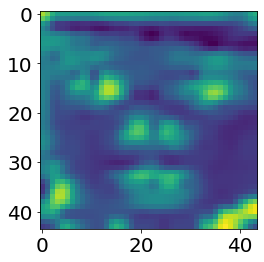

In [7]:
# rb2_s = torch.nn.functional.interpolate(torch.from_numpy(rb1_s).unsqueeze(0).unsqueeze(0), size=[44, 44], mode='nearest', align_corners=None).squeeze(0).squeeze(0)
m = torch.nn.Upsample(scale_factor=2, mode='bilinear')
rb2_s = m(torch.from_numpy(rb1_s).unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)
print (rb2_s.shape)
plt.figure("rb2_s") # 图像窗口名称
plt.imshow(rb2_s)
plt.axis('on') # 关掉坐标轴为 off
plt.tick_params(labelsize=20)
plt.savefig('./transformation/student_upsamping.jpg')
plt.show()

(22, 22)
torch.Size([20, 484])


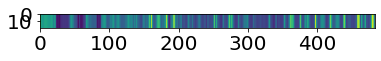

In [8]:
print (rb1_s.shape)
rb3_s = torch.from_numpy(rb1_s).view(1, 484).expand(20, 484)
print (rb3_s.shape)
plt.figure("rb3_s") # 图像窗口名称
plt.imshow(rb3_s)
plt.axis('on') # 关掉坐标轴为 off
plt.tick_params(labelsize=20)
# plt.title('A feature of ResBlock(1) in TeacherNet') # 图像题目
plt.savefig('./transformation/student_onevetor.jpg')
plt.show()

(484, 2116)


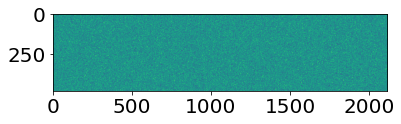

In [9]:
a = torch.rand(484, 2116)
parameter = torch.rand_like(a)
parameter = preprocess_feature2(parameter)
print (parameter.shape)
plt.figure("parameter") # 图像窗口名称
plt.imshow(parameter)
plt.axis('on') # 关掉坐标轴为 off
plt.tick_params(labelsize=20)
# plt.title('A feature of ResBlock(1) in TeacherNet') # 图像题目
plt.savefig('./transformation/parameter_matrix.jpg')
plt.show()

(22, 22)


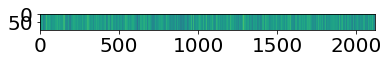

In [10]:
print (rb1_s.shape)
rb4_s = torch.from_numpy(rb1_s).view(1, 484)
rb4_s = rb4_s.mm(torch.from_numpy(parameter)).expand(100, 2116)
plt.figure("rb4_s") # 图像窗口名称
plt.imshow(rb4_s)
plt.axis('on') # 关掉坐标轴为 off
plt.tick_params(labelsize=20)
# plt.title('A feature of ResBlock(1) in TeacherNet') # 图像题目
plt.savefig('./transformation/student_onevetor_parameter.jpg')
plt.show()